https://colab.research.google.com/drive/1_45JKWScUBSMTIaubsuWXlJIlbwxT0WW?usp=sharing

# ST311 Group 5 Coursework
## Candidate Numbers: 28601, 24841, 32565

## Importing Packages

In [1]:
# Jamie
# importing libraries
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio
import torchaudio.transforms as T
import plotly.graph_objects as go
import numpy as np

In [2]:
# Jamie
N_MELS = 96
MEL_N_FFT = 4096*3
FIXED_SPECT_LENGTH = 4096*5 # reducing the number of timesteps linearly reduces RAM usage but also means the model trains on spectrograms with more cropping
HOP_LENGTH = 4096//20

DTYPE = torch.float32

In [3]:
# Jamie
# set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"USING DEVICE: {device}")

USING DEVICE: cuda


In [4]:
# Jamie
# setting default data type to float32 or bfloat32
torch.set_default_dtype(DTYPE)

## Pre-processing

In [5]:
# Jamie
def preprocess_audio(audio_path):
    dataset = load_dataset(audio_path)
    first_audio_data = dataset['train'][0]['audio']
    waveform = first_audio_data['array']
    sample_rate = first_audio_data['sampling_rate'] # sample rate
    waveform = torch.tensor(waveform).to(torch.float32)


    #waveform, sample_rate = torchaudio.load(audio_path, backend="soundfile")
    #waveform = waveform.to(torch.float32)  # cast waveform to float32
    waveform_std = torch.std(waveform)
    torch.set_default_dtype(torch.float32)
    spectrogram = T.MelSpectrogram(sample_rate=sample_rate, n_mels=N_MELS, n_fft=MEL_N_FFT, hop_length=HOP_LENGTH)(waveform)
    spectrogram = T.AmplitudeToDB()(spectrogram)
    spectrogram_mean = spectrogram.mean()
    spectrogram_std = (spectrogram-spectrogram_mean).std()
    spectrogram = (spectrogram - spectrogram.mean()) / spectrogram.std()  # normalize spectrogram
    spectrogram = spectrogram.to(DTYPE)
    torch.set_default_dtype(DTYPE)
    return spectrogram.squeeze(0), sample_rate, waveform_std, spectrogram_mean, spectrogram_std

In [6]:
# Jamie
def mel_frequencies(n_mels, sample_rate):
    """this function computes the Mel frequencies for a given number of Mel bins"""
    min_mel = 0
    max_mel = 2595 * np.log10(1 + (sample_rate / 2) / 700)
    mel_freqs = np.linspace(min_mel, max_mel, n_mels)
    mel_freqs = 700 * (10 ** (mel_freqs / 2595) - 1)
    return mel_freqs

## Loading Dataset

In [7]:
# Hassan
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


[notice] A new release of pip available: 22.2.2 -> 24.0
[notice] To update, run: c:\users\encha\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip



     ------------------------------------- 542.0/542.0 kB 11.3 MB/s eta 0:00:00
     --------------------------------------- 25.9/25.9 MB 17.2 MB/s eta 0:00:00
     ---------------------------------------- 116.3/116.3 kB ? eta 0:00:00
     ---------------------------------------- 133.4/133.4 kB ? eta 0:00:00


In [8]:
# Jamie
def load_data(data_path, noise_ratio=0.4):
    spectrograms = []
    for root, dirs, files in os.walk(data_path):
        for file in files[:4]:
            if file.endswith(".wav") and "ID30_pd_2_1_1.wav" not in file:
                print(file)
                audio_path = os.path.join(root, file)
                spectrogram, sample_rate, waveform_std, spectrogram_mean, spectrogram_std = preprocess_audio(audio_path)

                # add noise to the spectrogram
                noise = torch.randn_like(spectrogram) * noise_ratio * torch.var(spectrogram)
                noisy_spectrogram = (spectrogram * noise) + spectrogram * (1-noise_ratio)

                spectrograms.append((noisy_spectrogram, spectrogram, sample_rate, waveform_std, spectrogram_mean, spectrogram_std))
    return spectrograms

In [9]:
# Hassan
# importing and loading dataset
from datasets import load_dataset
dataset = load_dataset("Hahad14/Parkinsons_Disease_Speech")
spectrograms = dataset


Resolving data files:   0%|          | 0/74 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [10]:
# Jamie
def spectrogram_to_waveform(spectrogram, sample_rate):
    print("Converting spectrogram back to a waveform...")
    spectrogram = spectrogram.to(torch.float32)  # cast back to float32
    spectrogram = torch.pow(10.0, spectrogram / 20.0)  # convert the spectrogram from decibel scale back to amplitude
    spectrogram = (spectrogram - spectrogram.min()) / (spectrogram.max() - spectrogram.min())  # normalize the spectrogram to the range [0, 1]

    class InverseMelScale(T.InverseMelScale):  # invert the Mel scale
        def forward(self, melspec):
            self.fb = self.fb.to(melspec.device)  # move the Mel filterbank to the same device as the input
            return super().forward(melspec)

    inverse_mel_scale = InverseMelScale(sample_rate=sample_rate, n_stft=MEL_N_FFT // 2 + 1, n_mels=N_MELS)
    spectrogram = inverse_mel_scale(spectrogram)

    spectrogram = spectrogram.cpu()  # move the spectrogram to the CPU before applying GriffinLim
    griffinlim = T.GriffinLim(n_fft=MEL_N_FFT, hop_length=HOP_LENGTH, win_length=None, power=1, n_iter=25)  # create a GriffinLim object

    waveform = griffinlim(spectrogram.squeeze())  # convert spectrogram back to audio
    waveform = waveform.unsqueeze(0)  # add channel dimension

    return waveform

## Exploratory Data Analysis

In [11]:
# Jamie
import plotly.subplots as subplots
def plot_spectrogram(input_spectrogram, output_spectrogram):
  '''
  this function creates a spectrogram by converting our input audio into a short term fourier transform,
  converting these to decibels and the visualising these

  this function plots both the input and output Mel spectrograms, along with their difference.
  we padded the shorter spectrogram to match the length of the longer one.
  we display them as heatmaps.

  '''
  input_spectrogram = input_spectrogram.to(torch.float32)
  output_spectrogram = output_spectrogram.to(torch.float32)

  # pad the shorter spectrogram to match the length of the longer one
  if input_spectrogram.size(-1) < output_spectrogram.size(-1):
      pad_length = output_spectrogram.size(-1) - input_spectrogram.size(-1)
      input_spectrogram = F.pad(input_spectrogram, (0, pad_length), mode='constant', value=0)
  elif output_spectrogram.size(-1) < input_spectrogram.size(-1):
      pad_length = input_spectrogram.size(-1) - output_spectrogram.size(-1)
      output_spectrogram = F.pad(output_spectrogram, (0, pad_length), mode='constant', value=0)

  diff_spectrogram = output_spectrogram - input_spectrogram

  # compute the mel frequencies
  mel_freqs = mel_frequencies(N_MELS, sample_rate)

  # create subplots
  fig = subplots.make_subplots(rows=3, cols=1, vertical_spacing=0.1, subplot_titles=('Input Spectrogram', 'Output Spectrogram', 'Difference Spectrogram'))

  # input spectrogram
  fig.add_trace(go.Heatmap(
      z=input_spectrogram.cpu().numpy(),
      colorscale='Hot',
      y=mel_freqs,  # use mel frequencies for y-axis
      zmin=input_spectrogram.min().item(),
      zmax=input_spectrogram.max().item(),
      colorbar=dict(title='Amplitude (dB)'),
  ), row=1, col=1)

  # output spectrogram
  fig.add_trace(go.Heatmap(
      z=output_spectrogram.cpu().numpy(),
      colorscale='Hot',
      y=mel_freqs,  # use mel frequencies for y-axis
      zmin=output_spectrogram.min().item(),
      zmax=output_spectrogram.max().item(),
      colorbar=dict(title='Amplitude (dB)'),
  ), row=2, col=1)

  # difference spectrogram
  fig.add_trace(go.Heatmap(
      z=diff_spectrogram.cpu().numpy(),
      colorscale='RdBu',
      y=mel_freqs,  # use mel frequencies for y-axis
      zmin=diff_spectrogram.min().item(),
      zmax=diff_spectrogram.max().item(),
      colorbar=dict(title='Amplitude Difference (dB)'),
  ), row=3, col=1)

  fig.update_layout(
      title='Mel Spectrograms',
      xaxis_title='Time chunks of length ' + str(MEL_N_FFT),
      yaxis_title='Mel Frequency (Hz)',
      height=1200,
      width=2400,
      coloraxis_colorbar_y=0.2,  # move colorbars to the right side
  )

  fig.show()

In [13]:
# Hassan
import librosa
import librosa.display
import matplotlib.pyplot as plt

def create_spectrogram(data, sr, e):
  '''
  this function creates a spectrogram by converting our input audio into a short term fourier transform,
  converting these to decibels and the visualising these
  '''
  X = librosa.stft(data)
  Xdb = librosa.amplitude_to_db(abs(X))
  plt.figure(figsize=(12, 3))
  plt.title(f'Spectrogram for audio with label: {e}', size=15)
  librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
  plt.colorbar()
  plt.show()


In [15]:
# Jamie
import gc
import torch

def plot_latent_space(model, spectrograms):
    with torch.no_grad():
        # create a grid of points in the latent space
        n_points = 20
        z1_min, z1_max = -3, 3
        z2_min, z2_max = -3, 3
        z1 = np.linspace(z1_min, z1_max, n_points)
        z2 = np.linspace(z2_min, z2_max, n_points)
        Z1, Z2 = np.meshgrid(z1, z2)

        # reshape the grid to match the expected input shape of the decoder
        latent_grid = np.stack((Z1, Z2), axis=-1).reshape((-1, 2))
        latent_grid = np.pad(latent_grid, ((0, 0), (0, latent_dim - 2)), mode='constant')
        latent_grid = torch.tensor(latent_grid, dtype=torch.float32).to(device)

        reconstructed_spectrograms = model.decoder(latent_grid, torch.zeros_like(spectrograms[:1]).to(device)) # decode the latent grid to get the reconstructed spectrograms

        values = torch.std(reconstructed_spectrograms, dim=(1, 2, 3)).cpu().numpy() # dimensionality reduce each output spectrogram using some method eg sum,std,max,mean

        Z = values.reshape((n_points, n_points)) # reshape the max values to match the grid shape

        fig = go.Figure(data=[go.Surface(x=Z1, y=Z2, z=Z)])
        fig.update_layout(
            title='Latent Space Visualization',
            template='none',
            scene=dict(
                xaxis_title='Latent Dimension 1',
                yaxis_title='Latent Dimension 2',
                zaxis_title='Max Spectrogram Value'
            )
        )
        fig.show()

        # clear the cached tensors and release GPU memory
        del reconstructed_spectrograms
        del latent_grid
        torch.cuda.empty_cache()
        gc.collect()

### Audio File 1

The following code allows us to play the first 5 seconds of our .wav files in the colab.

In [16]:
# Hassan
import librosa
from IPython.display import Audio

first_audio_data = dataset['train'][0]['audio']
audio_data = first_audio_data['array']
sample_rate = first_audio_data['sampling_rate'] # sample rate

num_samples = 5 * sample_rate # no. of samples for 5 seconds
five_seconds_audio = audio_data[:num_samples]
Audio(five_seconds_audio, rate=sample_rate)

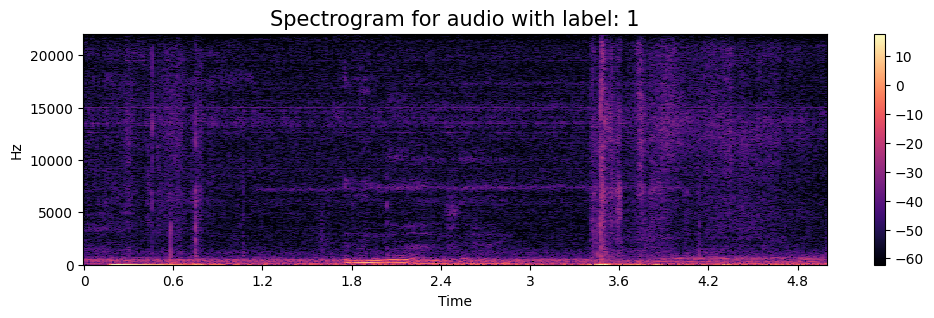

In [17]:
# Hassan
create_spectrogram(five_seconds_audio, sample_rate, '1') # plotting our spectrogram

The following code plots a waveform of the first 5 seconds, showing the amplitude over time:

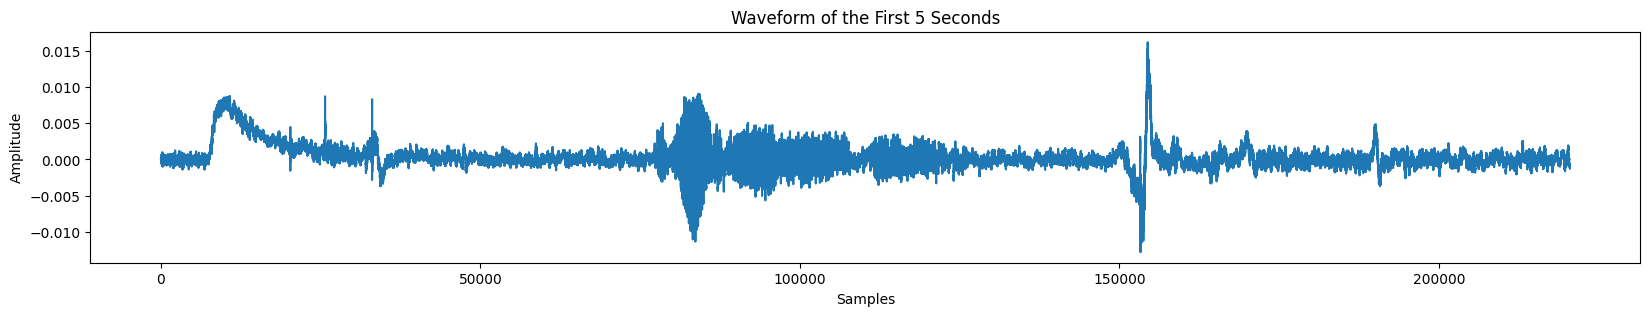

In [18]:
# Hassan
fig, ax = plt.subplots(figsize=(20, 3))
ax.plot(five_seconds_audio)
ax.set_title('Waveform of the First 5 Seconds')
ax.set_xlabel('Samples')
ax.set_ylabel('Amplitude')
plt.show()

### Audio File 6

In [19]:
# Hassan
first_audio_data = dataset['train'][5]['audio']
audio_data = first_audio_data['array']
sample_rate = first_audio_data['sampling_rate'] # sample rate

num_samples = 5 * sample_rate # no. of samples for 5 seconds
five_seconds_audio = audio_data[:num_samples]
Audio(five_seconds_audio, rate=sample_rate)

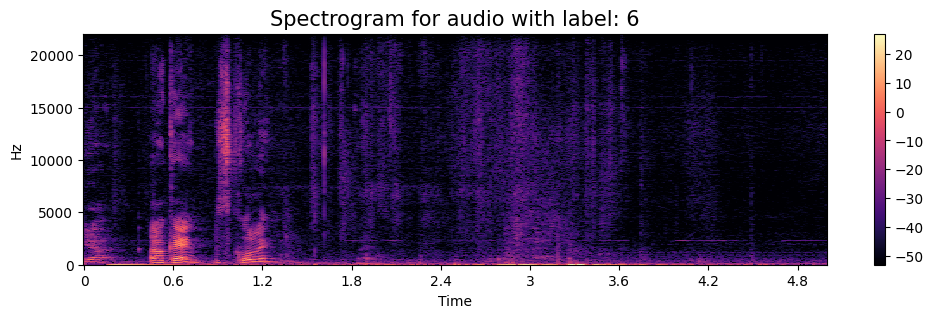

In [20]:
# Hassan
create_spectrogram(five_seconds_audio, sample_rate, '6')

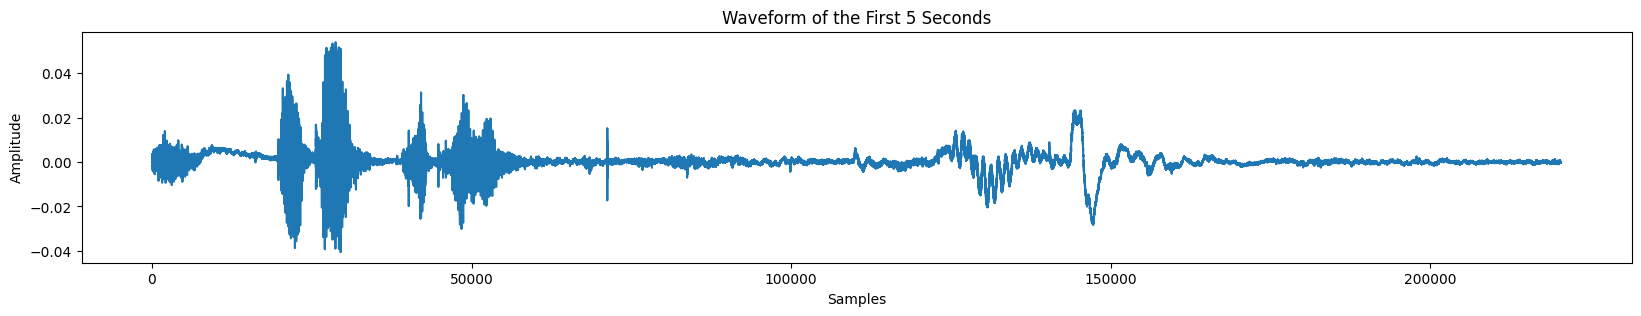

In [21]:
# Hassan
fig, ax = plt.subplots(figsize=(20, 3))
ax.plot(five_seconds_audio)
ax.set_title('Waveform of the First 5 Seconds')
ax.set_xlabel('Samples')
ax.set_ylabel('Amplitude')
plt.show()

### First 5 audio files

Spectrograms for the first 5 audio files, allowing us to compare them.

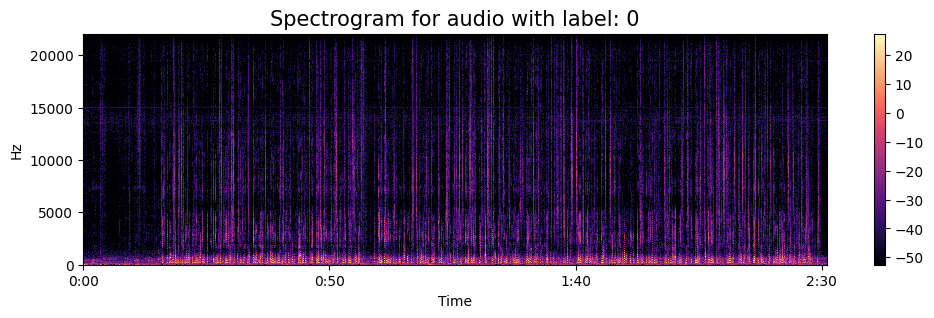

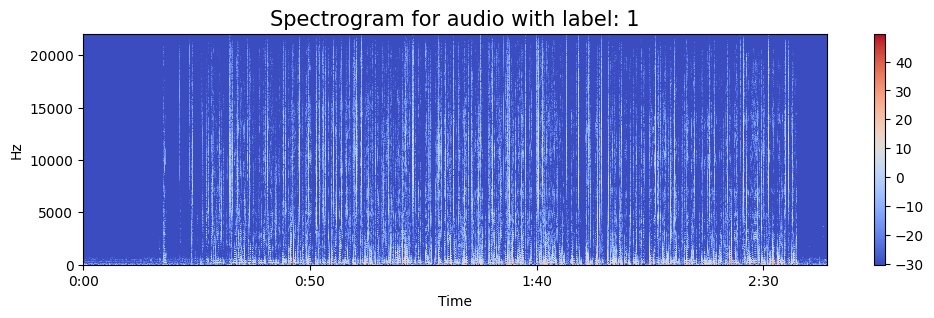

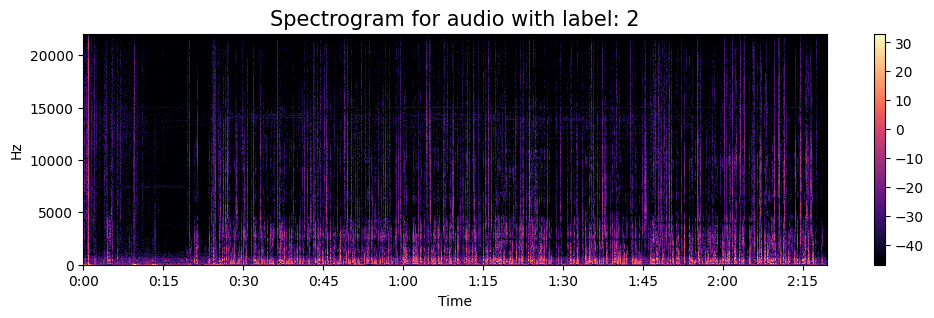

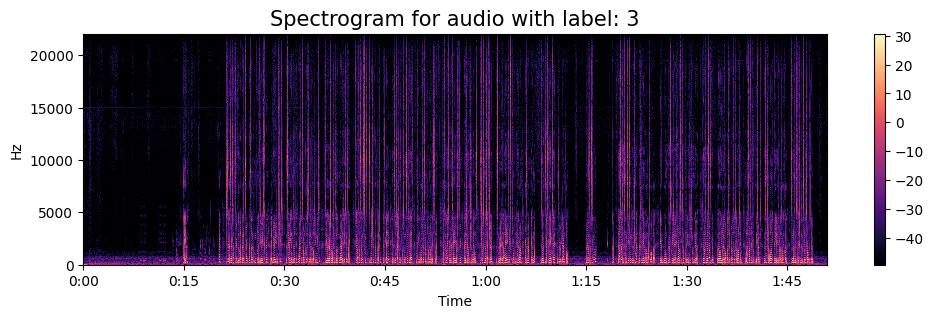

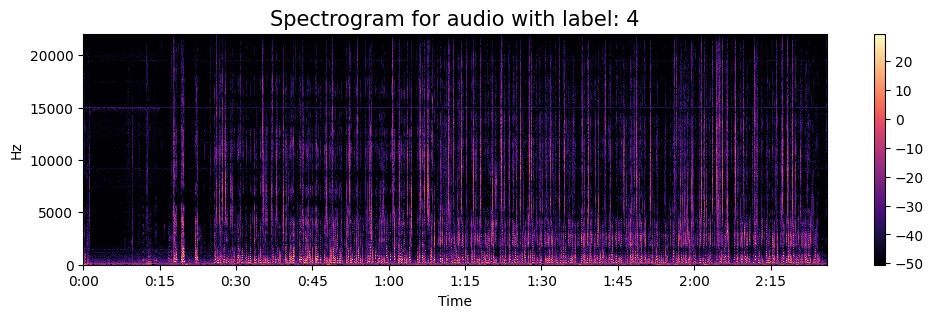

In [22]:
# Hassan
for i in range(5):
    audio_data = dataset['train'][i]['audio']['array']
    sample_rate = dataset['train'][i]['audio']['sampling_rate']
    #label = dataset['train'][i]['label']
    create_spectrogram(audio_data, sample_rate, i)

## Creating Model

### Plotting spectrograms

Firstly, we decided to plot spectrograms to visualise our audio files and allow us to compare these between healthy people (control) and people with Parkinson's Disease.

In [23]:
# Hassan
def preprocess_audio(audio_path):
  '''
  this function converts our audio files into Mel Spectrograms
  '''
  waveform, sample_rate = torchaudio.load(audio_path, backend="soundfile")
  spectrogram = T.MelSpectrogram(sample_rate=sample_rate, n_mels=128, n_fft=1024, hop_length=256)(waveform)
  spectrogram = T.AmplitudeToDB()(spectrogram)
  return spectrogram.squeeze(0), sample_rate


In [24]:
# Hassan
def plot_spectrogram(spectrogram):
  '''
  this function plots our spectrograms as heatmaps
  '''
  fig = go.Figure(data=go.Heatmap(z=spectrogram.numpy(), colorscale='Viridis'))
  fig.update_layout(title='Mel Spectrogram', xaxis_title='Time', yaxis_title='Mel Frequency')
  fig.show()

### Building VAE

Variational Autoencoder

1. Residual Block

   Our residual block uses 2 convolutional layers, ReLU, and a skip connection "residual" to bypass conv1 (to help protect against the vanishing gradient problem); allowing gradients to flow through network bypassing layers.

In [25]:
# Jamie
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.activation = nn.LeakyReLU(0.2)

    def forward(self, x):
        residual = x
        x = self.activation(self.conv1(x))
        x = self.conv2(x)
        x = x + residual
        x = self.activation(x)
        return x

2. VAE Encoder

    Our encoder model passes our input through 5 convolutional layers (ReLU) and residual blocks (further capturing complex patterns):

In [26]:
# Jamie
class Encoder(nn.Module):
    def __init__(self, input_channels, hidden_channels, latent_dim):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, hidden_channels, kernel_size=5, stride=2, padding=2) #First conv layer to map from input channels to hidden channels (on a new dimension)
        self.res_block1 = ResidualBlock(hidden_channels)
        self.conv2 = nn.Conv2d(hidden_channels, hidden_channels*2, kernel_size=5, stride=2, padding=2, groups=hidden_channels*1)
        self.res_block2 = ResidualBlock(hidden_channels*2)
        self.conv3 = nn.Conv2d(hidden_channels*2, hidden_channels*4, kernel_size=5, stride=2, padding=2, groups=hidden_channels*2)
        self.res_block3 = ResidualBlock(hidden_channels*4)
        self.conv4 = nn.Conv2d(hidden_channels*4, hidden_channels*8, kernel_size=5, stride=2, padding=2, groups=hidden_channels*4)
        self.res_block4 = ResidualBlock(hidden_channels*8)
        self.conv5 = nn.Conv2d(hidden_channels*8, hidden_channels*16, kernel_size=5, stride=2, padding=2, groups=hidden_channels*8)
        self.res_block5 = ResidualBlock(hidden_channels*16)
        self.flat_dim = (N_MELS // 32) * (FIXED_SPECT_LENGTH // 32) * hidden_channels*16
        self.fc1 = nn.Linear(self.flat_dim, hidden_channels*32)
        self.dropout1 = nn.Dropout(0.1)
        self.fc2 = nn.Linear(hidden_channels*32, hidden_channels*16)
        self.dropout2 = nn.Dropout(0.1)
        self.fc_mu = nn.Linear(hidden_channels*16, latent_dim)
        self.fc_logvar = nn.Linear(hidden_channels*16, latent_dim)
        self.leaky_relu = nn.LeakyReLU(0.1)

    @torch.autocast(device_type="cuda", dtype=DTYPE)
    def forward(self, x):
        residual = x
        x = self.leaky_relu(self.conv1(x))
        x = self.res_block1(x)
        x = self.leaky_relu(self.conv2(x))
        x = self.res_block2(x)
        x = self.leaky_relu(self.conv3(x))
        x = self.res_block3(x)
        x = self.leaky_relu(self.conv4(x))
        x = self.res_block4(x)
        x = self.leaky_relu(self.conv5(x))
        x = self.res_block5(x)
        x = x.view(x.size(0), -1)
        x = self.leaky_relu(self.fc1(x))
        x = self.dropout1(x)
        x = self.leaky_relu(self.fc2(x))
        x = self.dropout2(x)
        mu = self.fc_mu(x)
        log_var = self.fc_logvar(x)
        return mu, log_var, residual

3. VAE Decoder

   Our decoder model reconstructs the output by upsampling the latent representation, passing it through a series of TRANSPOSED convolutional layers and residual blocks. Additionally, we used a sigmoid activation for scaling, and a residual connection to blend our Decoder output with an interploated Encoder output.

In [27]:
# Jamie
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_channels, output_channels):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim, hidden_channels*16)
        self.dropout1 = nn.Dropout(0.1)
        self.fc2 = nn.Linear(hidden_channels*16, hidden_channels*32)
        self.dropout2 = nn.Dropout(0.1)
        self.fc3 = nn.Linear(hidden_channels*32, (N_MELS // 32) * (FIXED_SPECT_LENGTH // 32) * hidden_channels*16)
        self.dropout3 = nn.Dropout(0.1)
        self.deconv1 = nn.ConvTranspose2d(hidden_channels*16, hidden_channels*16, kernel_size=5, stride=2, padding=2, output_padding=1, groups=hidden_channels*16)
        self.res_block1 = ResidualBlock(hidden_channels*16)
        self.pointwise_deconv1 = nn.ConvTranspose2d(hidden_channels*16, hidden_channels*8, kernel_size=1)
        self.deconv2 = nn.ConvTranspose2d(hidden_channels*8, hidden_channels*8, kernel_size=5, stride=2, padding=2, output_padding=1, groups=hidden_channels*8)
        self.res_block2 = ResidualBlock(hidden_channels*8)
        self.pointwise_deconv2 = nn.ConvTranspose2d(hidden_channels*8, hidden_channels*8, kernel_size=1)
        self.deconv3 = nn.ConvTranspose2d(hidden_channels*8, hidden_channels*4, kernel_size=5, stride=2, padding=2, output_padding=1, groups=hidden_channels*4)
        self.res_block3 = ResidualBlock(hidden_channels*4)
        self.pointwise_deconv3 = nn.ConvTranspose2d(hidden_channels*4, hidden_channels*4, kernel_size=1)
        self.deconv4 = nn.ConvTranspose2d(hidden_channels*4, hidden_channels*2, kernel_size=5, stride=2, padding=2, output_padding=1, groups=hidden_channels*2)
        self.res_block4 = ResidualBlock(hidden_channels*2)
        self.pointwise_deconv4 = nn.ConvTranspose2d(hidden_channels*2, hidden_channels, kernel_size=1)
        self.deconv5 = nn.ConvTranspose2d(hidden_channels, hidden_channels, kernel_size=5, stride=2, padding=2, output_padding=1, groups=hidden_channels*1)
        self.res_block5 = ResidualBlock(hidden_channels)
        self.pointwise_deconv5 = nn.ConvTranspose2d(hidden_channels, output_channels, kernel_size=1)
        self.residual_conv = nn.Conv2d(output_channels, output_channels, kernel_size=1, groups=output_channels)
        self.leaky_relu = nn.LeakyReLU(0.2)

    @torch.autocast(device_type="cuda", dtype=DTYPE)
    def forward(self, z, residual):
        x = self.leaky_relu(self.fc1(z))
        x = self.dropout1(x)
        x = self.leaky_relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.leaky_relu(self.fc3(x))
        x = self.dropout3(x)
        x = x.view(x.size(0), -1, N_MELS // 32, FIXED_SPECT_LENGTH // 32)
        x = self.leaky_relu(self.deconv1(x))
        x = self.res_block1(x)
        x = self.leaky_relu(self.pointwise_deconv1(x))
        x = self.leaky_relu(self.deconv2(x))
        x = self.res_block2(x)
        x = self.leaky_relu(self.pointwise_deconv2(x))
        x = self.leaky_relu(self.deconv3(x))
        x = self.res_block3(x)
        x = self.leaky_relu(self.pointwise_deconv3(x))
        x = self.leaky_relu(self.deconv4(x))
        x = self.res_block4(x)
        x = self.leaky_relu(self.pointwise_deconv4(x))
        x = self.leaky_relu(self.deconv5(x))
        x = self.res_block5(x)
        x = torch.sigmoid(self.pointwise_deconv5(x))

        # incorporate the residual connection
        residual = F.interpolate(residual, size=x.shape[2:], mode='bilinear', align_corners=False)
        residual_weight = torch.sigmoid(self.residual_conv(x))
        x = ((residual * residual_weight) * x) * 0.5 + x * 0.5

        return x


### Constructing VAE

We now actually construct the VAE, and start training it to accurately reconstruct our initial input.

In [28]:
# Jamie
class VAE(nn.Module):
    def __init__(self, input_channels, hidden_channels, latent_dim):
        super(VAE, self).__init__()
        self.encoder = Encoder(input_channels, hidden_channels, latent_dim)
        self.decoder = Decoder(latent_dim, hidden_channels, input_channels)

    def forward(self, x):
        mu, log_var, residual = self.encoder(x)
        z = self.reparameterize(mu, log_var)
        x_recon = self.decoder(z, residual)
        return x_recon, mu, log_var

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

In [29]:
# Jamie
# training loop
def train(model, dataloader, optimizer, scheduler=None):
    model.train()
    for conv_layer in [model.encoder.conv1, model.encoder.conv2, model.encoder.conv3, model.encoder.conv4, model.encoder.conv5]:
        nn.init.kaiming_normal_(conv_layer.weight, mode='fan_in', nonlinearity='leaky_relu')
    for epoch in range(num_epochs):
        epoch_loss = 0
        for i, (noisy_spectrograms, clean_spectrograms, _) in enumerate(dataloader): #_ here is sample rate, which we know is the same for all files
            noisy_spectrograms = noisy_spectrograms.to(device).to(DTYPE)  # convert input to float16
            clean_spectrograms = clean_spectrograms.to(device).to(DTYPE)  # convert input to float16

            optimizer.zero_grad()
            with torch.cuda.amp.autocast(dtype=DTYPE):
                reconstructed_spectrograms, mu, log_var = model(noisy_spectrograms)
                reconstruction_loss = F.l1_loss(reconstructed_spectrograms, clean_spectrograms)
                kl_divergence = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
                beta = 0.15  # beta-VAE loss coefficient # lower values lets it 'overfit' more and regularise the latent space less. higher values makes our latent space graph look more 'noisy' as a result.
                loss = reconstruction_loss + beta * kl_divergence  # combine losses with weighting factor

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            epoch_loss += loss.item()

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss / len(dataloader):.4f}")
        if scheduler:
            scheduler.step(epoch_loss / len(dataloader))

We created an inference function that doesn't update the model weights (no fine tuning our model):


In [30]:
# Jamie
# inference
def inference(model, spectrogram):
    with torch.no_grad():
        spectrogram = spectrogram.to(device)

        # pad the spectrogram to match the fixed_size used during training
        pad_length = FIXED_SPECT_LENGTH - spectrogram.size(-1)
        padded_spectrogram = F.pad(spectrogram, (0, pad_length), mode='constant', value=0)

        padded_spectrogram = padded_spectrogram.unsqueeze(0).unsqueeze(0)  # add batch and channel dimensions
        reconstructed_spectrogram, _, _ = model(padded_spectrogram)

        # remove padding from the reconstructed spectrogram
        reconstructed_spectrogram = reconstructed_spectrogram.squeeze(0).squeeze(0)[:, :spectrogram.size(-1)]
        reconstructed_spectrogram = reconstructed_spectrogram.to(torch.float32)  # cast back to float32
    return reconstructed_spectrogram

We then created a custom collate function to ensure all of the spectrograms in our batch were the same size, by padding them all to the maximum size.

In [31]:
# Jamie
# custom collate function
def collate_fn(batch):
    noisy_spectrograms, clean_spectrograms, sample_rates = zip(*batch)

    # pad the spectrograms to a fixed size
    padded_noisy_batch = []
    padded_clean_batch = []
    for noisy_spec, clean_spec in zip(noisy_spectrograms, clean_spectrograms):
        pad_length = FIXED_SPECT_LENGTH - noisy_spec.size(-1)
        padded_noisy_spec = F.pad(noisy_spec, (0, pad_length), mode='constant', value=0)
        padded_clean_spec = F.pad(clean_spec, (0, pad_length), mode='constant', value=0)
        padded_noisy_batch.append(padded_noisy_spec)
        padded_clean_batch.append(padded_clean_spec)

    # stack the padded spectrograms into single tensors
    stacked_noisy_spectrograms = torch.stack(padded_noisy_batch)
    stacked_clean_spectrograms = torch.stack(padded_clean_batch)

    return stacked_noisy_spectrograms.unsqueeze(1), stacked_clean_spectrograms.unsqueeze(1), sample_rates[0]

## Noise reduction

Our audio recordings were recorded in a KCL hospital examination room (with a reverberation tone of ~500ms), using a Motorola Mota G4 Smartphone.

Hence, we decided that in order to optimise our model's fit, we needed to denoise our audio files as much as possible.

In [32]:
# Hassan
!pip install noisereduce

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     ------------------------------------- 253.7/253.7 kB 16.2 MB/s eta 0:00:00
     ---------------------------------------- 75.1/75.1 kB ? eta 0:00:00
     ---------------------------------------- 184.8/184.8 kB ? eta 0:00:00
     ---------------------------------------- 63.0/63.0 kB ? eta 0:00:00
     -------------------------------------- 952.8/952.8 kB 6.0 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 65.4.1
    Uninstalling setuptools-65.4.1:
      Successfully uninstalled setuptools-65.4.1


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-intel 2.13.0 requires typing-extensions<4.6.0,>=3.6.6, but you have typing-extensions 4.11.0 which is incompatible.
lean 1.0.118 requires requests>=2.27.1, but you have requests 2.25.0 which is incompatible.

[notice] A new release of pip available: 22.2.2 -> 24.0
[notice] To update, run: c:\users\encha\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip


This is the original raw first 10 seconds of the .wav 21st audio file:

In [33]:
# Hassan
first_audio_data = dataset['train'][21]['audio']
audio_data = first_audio_data['array']
sample_rate = first_audio_data['sampling_rate'] # sample rate

num_samples = 10 * sample_rate # no. of samples for 10 seconds
five_seconds_audio = audio_data[:num_samples]
Audio(five_seconds_audio, rate=sample_rate)

In [34]:
# Hassan
import noisereduce as nr
reduced_noise = nr.reduce_noise(y=five_seconds_audio, sr=sample_rate)

ModuleNotFoundError: No module named 'noisereduce'

This is the first 10 seconds of the 21st audio file AFTER we have denoised it:

In [ ]:
# Hassan
Audio(data=reduced_noise, rate=sample_rate)

Listening to this, we can tell that it has much less background noise compared to the raw version.

## Speech to Text - WEÏRD HASSAN SECTION

speech to text using hugging face

In [ ]:
# Hassan
from transformers import pipeline

transcriber = pipeline("automatic-speech-recognition", model="microsoft/speecht5_asr")


In [ ]:
# Hassan
transcriber(reduced_noise)

facebook instead

In [ ]:
# Hassan
# Use a pipeline as a high-level helper
from transformers import pipeline

pipe = pipeline("automatic-speech-recognition", model="facebook/s2t-small-librispeech-asr")

In [ ]:
# Hassan
pipe(five_seconds_audio)

In [ ]:
# Hassan
# Use a pipeline as a high-level helper
from transformers import pipeline

pipe = pipeline("automatic-speech-recognition", model="openai/whisper-large")

In [ ]:
# Hassan
pipe(five_seconds_audio)

In [ ]:
# Hassan
pipe(reduced_noise)

once we have the text of what the person is saying we can now feed to coqui tts . it learns the accent by using a voice recording giving a personalised feel to the speech generated.

In [ ]:
# Hassan
pip install TTS

In [ ]:
# Hassan
from TTS.api import TTS
tts = TTS("tts_models/multilingual/multi-dataset/xtts_v2", gpu=True)

# generate speech by cloning a voice using default settings


In [ ]:
# Hassan
tts.tts_to_file(text="This AI project is not only fascinating but also stands out due to its far-reaching implications and potential applications. By leveraging advanced technologies, it promises to innovate and transform the landscape, offering solutions that could have a profound impact across various fields." ,
                file_path="/content/Hoarsy.wav",
                speaker_wav="/content/Phil.wav",
                language="en")


Git cloning!

In [36]:
!git clone https://github.com/portaljumper007/ST311-Final-Group-Project.git

Cloning into 'ST311-Final-Group-Project'...


## Jamie's broken code

In [39]:
# Jamie
if __name__ == "__main__":
    print("Starting...")

    # Hyperparameters
    num_epochs = 400
    batch_size = 4096
    learning_rate = 5e-4
    latent_dim = 1024
    hidden_channels = 4

    # Create VAE model
    input_channels = 1
    model = VAE(input_channels, hidden_channels, latent_dim).to(device)

    # Create dataloader
    data_path = "26_29_09_2017_KCL\\26-29_09_2017_KCL"
    spectrograms = load_data(data_path)
    print(f"Number of spectrograms: {len(spectrograms)}")

    # Plot an example spectrogram
    #_, example_spectrogram, _ = spectrograms[0]
    #plot_spectrogram(example_spectrogram.cpu())
    input_spectrogram, sample_rate, waveform_std, spectrogram_mean, spectrogram_std = preprocess_audio("26_29_09_2017_KCL\\26-29_09_2017_KCL\\ReadText\\PD\\ID30_pd_2_1_1.wav")
    print("Input volume (std of waveform):", waveform_std)
    print("Input spectrogram mean:", spectrogram_mean, "Input spectrogram std:", spectrogram_std)

    dataloader = torch.utils.data.DataLoader(spectrograms, batch_size=batch_size, shuffle=True, collate_fn=collate_fn, pin_memory=True if torch.cuda.is_available() else False)

    # Train model
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-5, amsgrad=True)
    #scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, verbose=True)
    train(model, dataloader, optimizer)#, scheduler)



    # Plot the latent space
    batch = next(iter(dataloader))
    input_spectrograms = batch[0].to(device)
    plot_latent_space(model, input_spectrograms)



    # Perform inference
    print("Inference..")
    output_spectrogram = inference(model, input_spectrogram)

    #output_spectrogram += spectrogram_mean
    output_spectrogram = (output_spectrogram - output_spectrogram.mean()) / output_spectrogram.std()
    output_spectrogram *= spectrogram_std
    output_spectrogram += spectrogram_mean
    plot_spectrogram(input_spectrogram.cpu(), output_spectrogram.cpu()) # Plot the input, output, and difference spectrograms

    output_waveform = spectrogram_to_waveform(output_spectrogram, sample_rate)
    print("Saving...")
    print("Output volume (std of waveform) BEFORE rescaling:", output_waveform.std())
    # Rescale the output waveform to match the input volume
    torchaudio.save("output_audio.wav", output_waveform * (waveform_std / output_waveform.std()), sample_rate)

    input_waveform = spectrogram_to_waveform(input_spectrogram, sample_rate)
    input_waveform = input_waveform[:, :output_waveform.size(-1)] # Crop the input waveform to match the length of the output waveform
    diff_waveform = ((input_waveform/input_waveform.std()) - (output_waveform/output_waveform.std()))
    torchaudio.save("output_audio_DIFF.wav", diff_waveform / diff_waveform.std(), sample_rate)
    #torchaudio.save("test_unaltered_input_pipeline_audio.wav", input_waveform, sample_rate)

    print("Done! File saved.")

Starting...
Number of spectrograms: 0


LibsndfileError: Error opening '26_29_09_2017_KCL\\26-29_09_2017_KCL\\ReadText\\PD\\ID30_pd_2_1_1.wav': System error.